The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


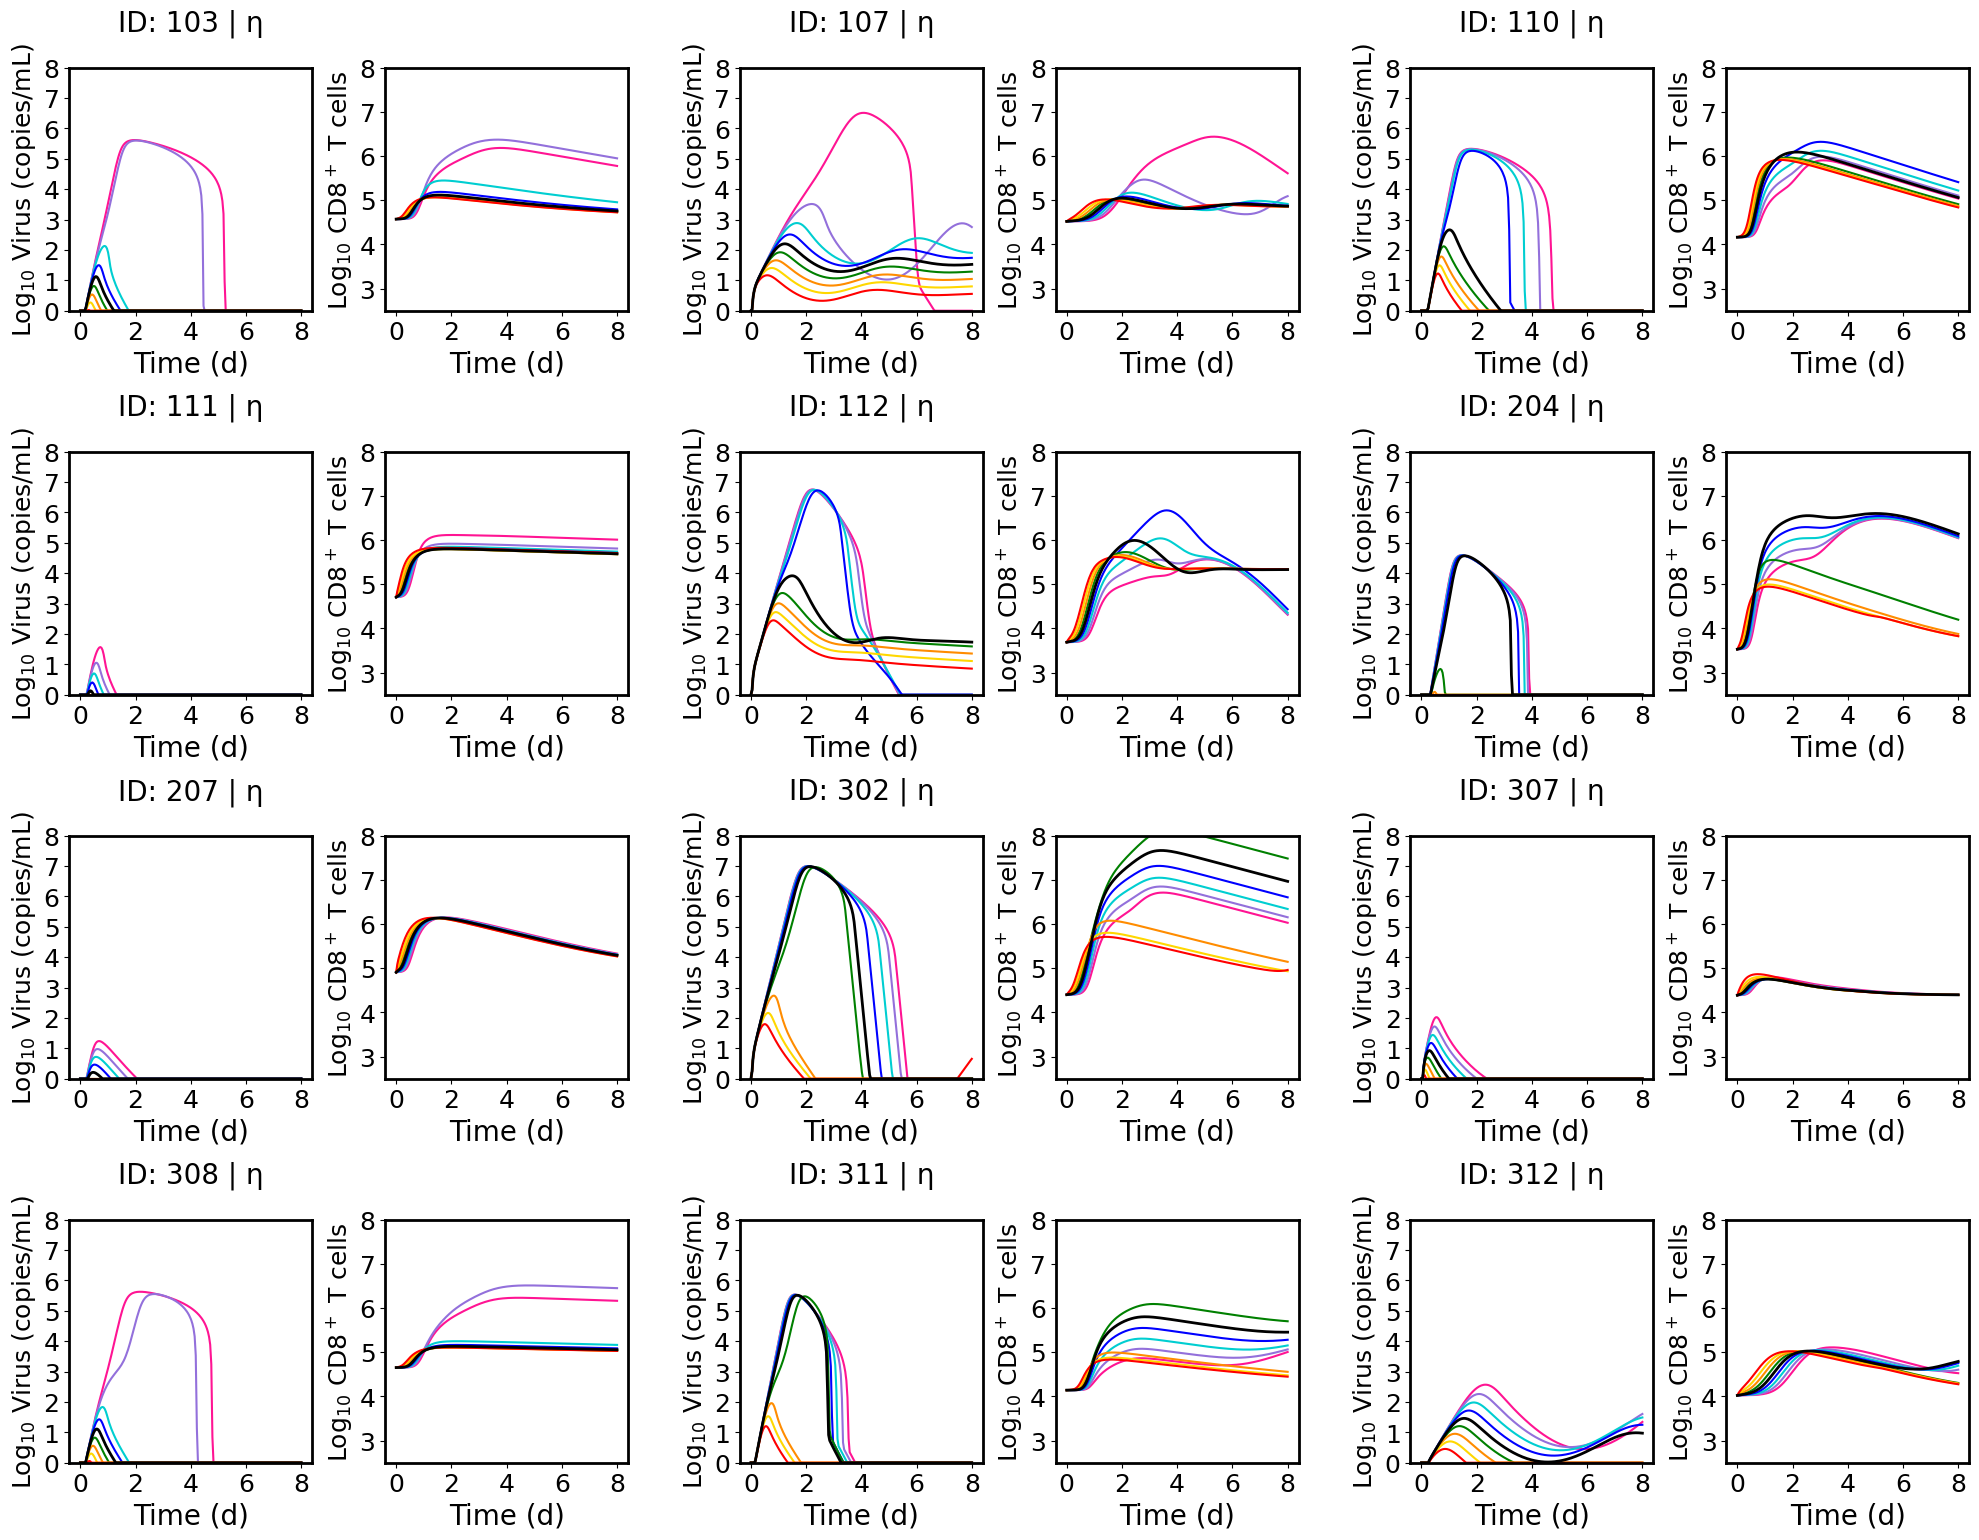

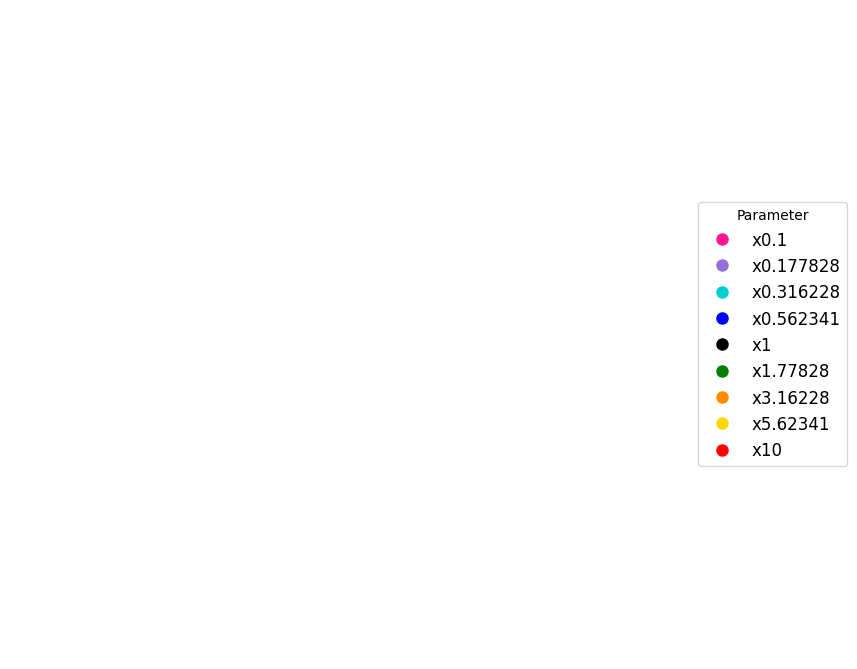

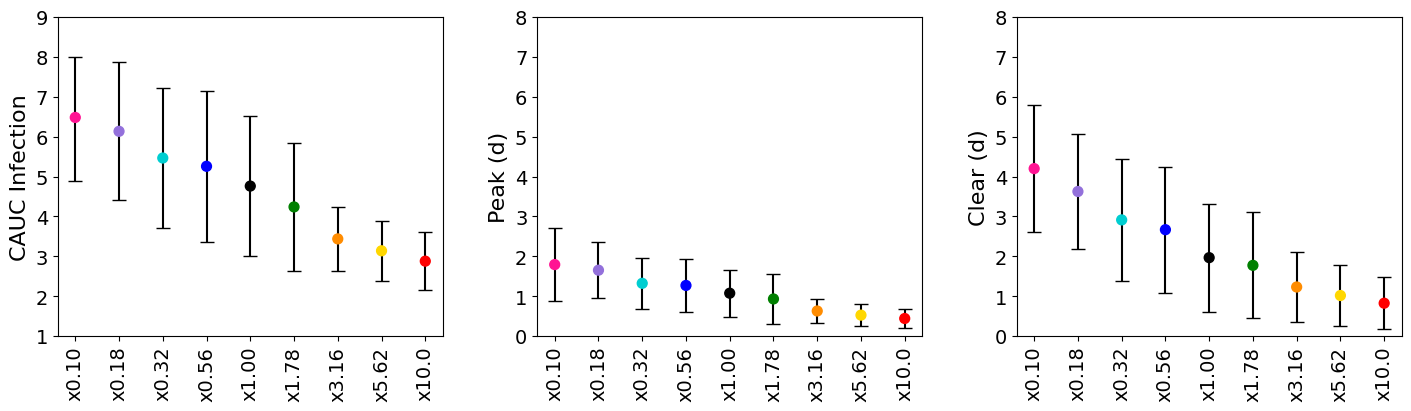

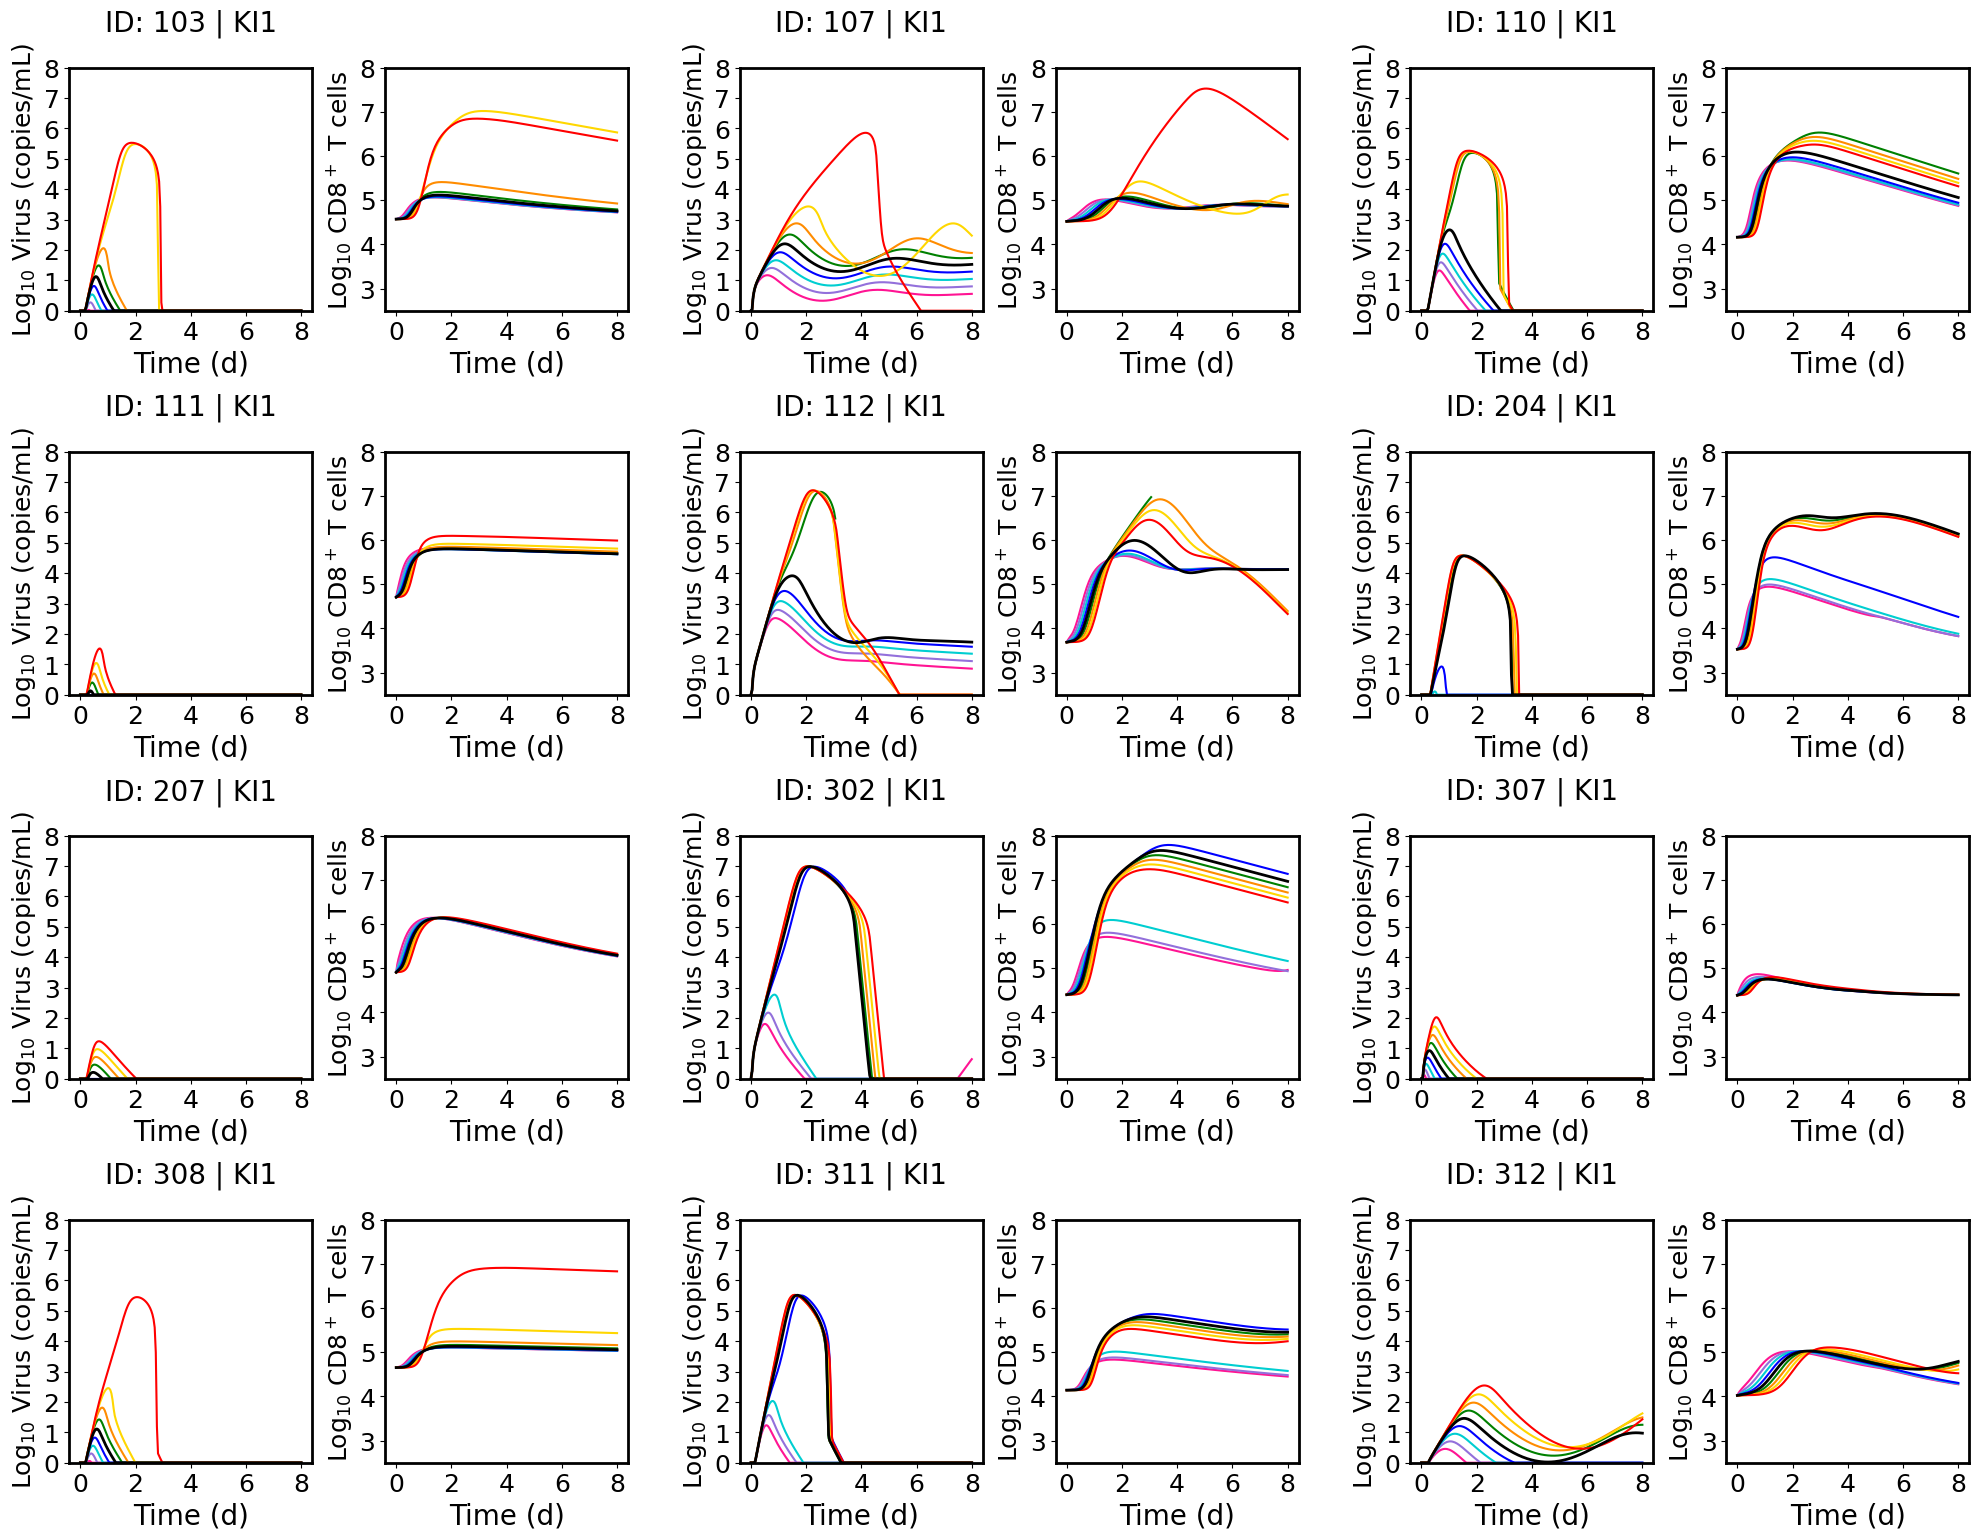

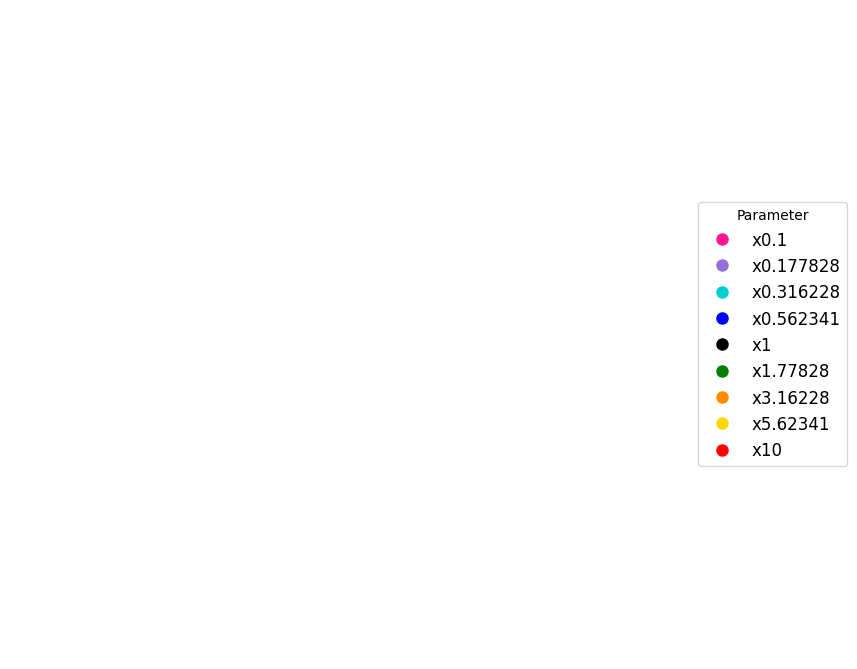

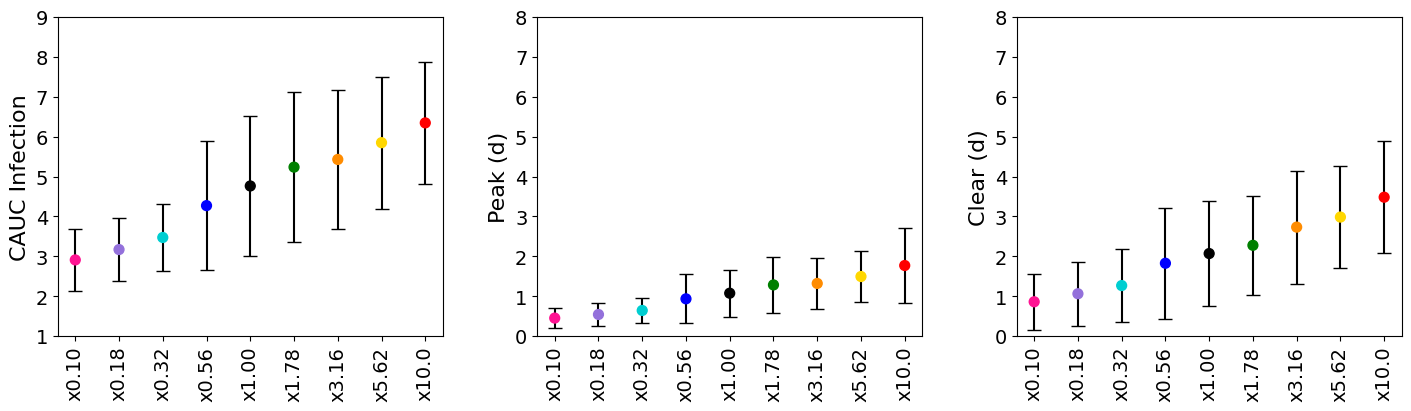

In [48]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from matplotlib.colors import to_rgb

try:
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')
except Exception as e:
    pass

os.environ["JULIA_NUM_THREADS"] = "4"
from julia.api import Julia
julia = Julia(sysimage="../sysimage_env/sysimage.so")
from julia import Main
Main.include("../models/Primary_model.jl")
Main.include("../models/Reinfection_model.jl") 

from goose import sci_format, format_fit_params, read_excel

def run_simulation(t_span, y0, base_params, sweep_param, percent=None, log=None):
    base_value = base_params[sweep_param]
    n_points = 9
    if percent is not None and log is None:
        sweep_range = (base_value * (1 - percent/100), base_value * (1 + percent/100))
        sweep_values = np.linspace(sweep_range[0], sweep_range[1], n_points)
    elif log is not None and percent is None:
        sweep_range = (base_value * (10 ** -log), base_value * (10 ** log))
        sweep_values = 10 ** np.linspace(np.log10(sweep_range[0]), np.log10(sweep_range[1]), n_points)
    else:
        raise ValueError("Either percent or log must be provided exclusively.")
        
    # Prepare a constant y0 for all simulations (using base T0 and ME)
    y0_sim = y0.copy()
    y0_sim[0] = base_params["T0"]
    y0_sim[5] = Zero_conditions["MP0"]
    y0_sim = [float(x) for x in y0_sim]
    
    param_order = ["beta", "k", "p", "c", "delta", "xi", "a", 
                   "d_E", "delta_E", "K_delta_E", "zeta", "eta", "K_I1", 
                   "tau_memory", "damp"]
    
    # Build a batch (list) of parameter sets for all sweep values.
    # For each run, we start with the base parameters (excluding T0 and ME)
    # and then override the swept parameter.
    param_sets = []
    for value in sweep_values:
        params = {k: base_params[k] for k in base_params if k not in ["T0", "MP0"]}
        params[sweep_param] = value
        param_set = [float(np.float64(params[key])) for key in param_order]
        param_sets.append(param_set)
    
    # *** Convert each parameter set to a native Julia Vector{Float64} ***
    # This forces PyCall to recognize each inner list as an AbstractVector.
    # Here we build a Julia array literal string (e.g., "[1.0,2.0,...]") and evaluate it.
    param_sets = [Main.eval("[" + ",".join(map(str, p)) + "]") for p in param_sets]
        
    t_fill = np.linspace(t_span[0], t_span[-1], 200)
    t_int = np.arange(t_span[0], t_span[-1] + 1)
    t_span = np.unique(np.concatenate([t_span, t_fill, t_int]))
    # Run all simulations in parallel (ThreadsX in Julia)
    results = Main.tmap_ReinfectionModel(t_span, y0_sim, param_sets)
    
    # Convert the Julia results into a list of dictionaries with numpy arrays
    solutions = []
    for res in results:
        t_values = np.array(res[0], dtype=np.float64)
        y_values = np.array(res[1], dtype=np.float64)
        solutions.append({"t": t_values, "y": y_values})
    
    # Compute key metrics: cumulative infection (CAUC), time of peak virus, and clearance day.
    cauc_values, peak_days, clear_days = [], [], []
    for sol in solutions:
        t_arr = sol["t"]
        virus = sol["y"][3, :]
        infection = sol["y"][1, :] + sol["y"][2, :]
        auc = np.trapezoid(infection, t_arr)
        cauc_values.append(auc)
        peak_idx = np.argmax(virus)
        peak_days.append(t_arr[peak_idx])
        clear_time = np.nan
        for i in range(peak_idx+1, len(t_arr)):
            if virus[i] < 1:
                clear_time = t_arr[i]
                break
        clear_days.append(clear_time)
        
    # Run a baseline simulation (with unswept base parameters)
    baseline_params = {k: base_params[k] for k in base_params if k not in ["T0", "MP0"]}
    baseline_param_set = [float(np.float64(baseline_params[key])) for key in param_order]
    # Convert baseline_param_set to a native Julia vector
    baseline_param_set = Main.eval("[" + ",".join(map(str, baseline_param_set)) + "]")
    
    baseline_y0 = y0.copy()
    baseline_y0[0] = base_params["T0"]
    baseline_y0[5] = Zero_conditions["MP0"]
    baseline_y0 = [float(x) for x in baseline_y0]
    baseline_result = Main.tmap_ReinfectionModel(t_span, baseline_y0, baseline_param_set)
    # Since tmap_ReinfectionModel wraps a single set in a list, extract the first element
    baseline_tuple = baseline_result[0]
    baseline = {"t": np.array(baseline_tuple[0], dtype=np.float64),
                "y": np.array(baseline_tuple[1], dtype=np.float64)}
                
    # Use n_points (9) instead of 11 for tick values.
    if log is not None:
        subset_tick_values = 10 ** np.linspace(np.log10(sweep_range[0]), np.log10(sweep_range[1]), n_points)
    else:
        subset_tick_values = np.linspace(sweep_range[0], sweep_range[1], n_points)
        
    dynamics_indices = []
    for tick in subset_tick_values:
        if np.isclose(tick, base_value):
            continue
        idx = np.argmin(np.abs(sweep_values - tick))
        dynamics_indices.append(idx)
    dynamics_indices = np.array(dynamics_indices)
    
    return {
        "sweep_values": sweep_values,
        "solutions": solutions,
        "baseline": baseline,
        "cauc_values": np.array(cauc_values),
        "peak_days": np.array(peak_days),
        "clear_days": np.array(clear_days),
        "subset_tick_values": subset_tick_values,
        "dynamics_indices": dynamics_indices,
        "base_value": base_value,
        "sweep_range": sweep_range
    }

def plot_individual_dynamics(fig, cell_gs, sim_data, t_span, Zero_conditions, sweep_param, indiv_id, log):

    # Define fixed color mappings.
    decrease_colors = ["deeppink", "mediumpurple", "darkturquoise", "blue"]
    increase_colors = ["green", "darkorange", "gold", "red"]
    baseline_color = "black"
    
    gs_dyn = mpl.gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=cell_gs, wspace=0.3)
    ax_virus = fig.add_subplot(gs_dyn[0])
    ax_effector = fig.add_subplot(gs_dyn[1])
    
    for spine in ax_virus.spines.values():
        spine.set_color('black')
        spine.set_linewidth(2)
    for spine in ax_effector.spines.values():
        spine.set_color('black')
        spine.set_linewidth(2)
    
    base_value = sim_data["base_value"]
    sweep_values = sim_data["sweep_values"]
    solutions = sim_data["solutions"]
    dynamics_indices = sim_data["dynamics_indices"]
    
    # Find the index corresponding to the baseline.
    baseline_index = np.where(np.isclose(sweep_values, base_value))[0][0]
    
    # Plot each simulation (non-baseline).
    for idx in dynamics_indices:
        if idx < baseline_index:
            color = decrease_colors[idx]  # For indices 0,1,2,3.
        elif idx > baseline_index:
            color = increase_colors[idx - baseline_index - 1]  # For indices 5,6,7,8.
        else:
            color = baseline_color  # In case the baseline appears here.
        sol = solutions[idx]
        ax_virus.plot(sol["t"], np.log10(np.maximum(sol["y"][3, :], 1)),
                      color=color, linewidth=1.5)
        ax_effector.plot(sol["t"], np.log10(np.maximum(sol["y"][4, :] + sol["y"][5, 0], 1)),
                         color=color, linewidth=1.5)
    
    # Plot the baseline simulation in black.
    baseline = sim_data["baseline"]
    ax_virus.plot(baseline["t"], np.log10(np.maximum(baseline["y"][3, :], 1)),
                  color=baseline_color, linewidth=2)
    ax_effector.plot(baseline["t"], np.log10(np.maximum(baseline["y"][4, :] + Zero_conditions["MP0"], 1)),
                     color=baseline_color, linewidth=2)
    
    ax_virus.set_yticks(np.arange(0, 9, 1))
    ax_effector.set_yticks(np.arange(2, 9, 1))
    ax_virus.set_xticks([0, 2, 4, 6, 8])
    ax_effector.set_xticks([0, 2, 4, 6, 8])
    ax_virus.set_ylabel('Log$_{10}$ Virus (copies/mL)', fontsize=18)
    ax_effector.set_ylabel('Log$_{10}$ CD8$^+$ T cells', fontsize=18)
    ax_virus.set_xlabel("Time (d)", fontsize=20)
    ax_effector.set_xlabel("Time (d)", fontsize=20)
    ax_virus.tick_params(labelsize=18)
    ax_effector.tick_params(labelsize=18)
    ax_virus.set_ylim(0, 8)
    ax_effector.set_ylim(2.5, 8)
    ax_virus.set_box_aspect(1)
    ax_effector.set_box_aspect(1)
    ax_virus.text(0.5, 1.15, f"ID: {indiv_id} | {format_fit_params(sweep_param)}",
                  transform=ax_virus.transAxes, fontsize=20, ha='center')
    
    plt.savefig(f'../plots/sensitivity/parameter/{indiv_id}_dynamics_{format_fit_params(sweep_param)}.svg',
                format='svg', bbox_inches='tight')

def create_global_legend(fig, rep_sim, log):

    # Fixed discrete color definitions.
    decrease_colors = ["deeppink", "mediumpurple", "darkturquoise", "blue"]
    increase_colors = ["green", "darkorange", "gold", "red"]
    baseline_color = "black"

    rep_sweep = np.array(rep_sim["sweep_values"])
    rep_base = rep_sim["base_value"]
    # Find the index of the baseline value in the full sweep array.
    baseline_index = np.argmin(np.abs(rep_sweep - rep_base))

    subset_ticks = rep_sim["subset_tick_values"]

    legend_elements = []
    for val in subset_ticks:
        # Get the index of the closest value in rep_sweep.
        idx_val = np.argmin(np.abs(rep_sweep - val))
        if np.isclose(val, rep_base):
            color = baseline_color
        elif val < rep_base:
            color = decrease_colors[idx_val]  # Expect idx_val in [0,1,2,3].
        else:
            # For values above baseline, subtract baseline_index+1 to index into increase_colors.
            color = increase_colors[idx_val - baseline_index - 1]
        # Compute the multiplier relative to the baseline.
        multiplier = val / rep_base
        label = "x1" if np.isclose(multiplier, 1) else f"x{multiplier:g}"
        legend_elements.append(mpl.lines.Line2D([0], [0],
                                                  marker='o',
                                                  color='w',
                                                  markerfacecolor=color,
                                                  markersize=10,
                                                  label=label))

    # Create a dummy axis and add the legend.
    ax = fig.add_subplot(111)
    ax.axis("off")
    ax.legend(handles=legend_elements,
              title="Parameter",
              loc="center left",
              bbox_to_anchor=(0.85, 0.5),
              fontsize=12)

def plot_summary_metrics(fig, cell_gs, sim_data_list, sweep_param, log, ylims_auc, ylims_peak, ylims_clear):

    decrease_colors = ["deeppink", "mediumpurple", "darkturquoise", "blue"]
    increase_colors = ["green", "darkorange", "gold", "red"]
    baseline_color = "black"
    
    gs_met = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=cell_gs, wspace=0.1)
    ax_auc   = fig.add_subplot(gs_met[0])
    ax_peak  = fig.add_subplot(gs_met[1])
    ax_clear = fig.add_subplot(gs_met[2])

    base_data = sim_data_list[0]
    sweep_values = base_data["sweep_values"]  
    base_value = base_data["base_value"]
    
    multipliers = sweep_values / base_value  
    x_coords = np.log10(multipliers) if log is not None else multipliers
    
    # Compute marker colors for each of the 9 sweep points.
    baseline_index = np.argmin(np.abs(sweep_values - base_value))
    marker_colors = []
    for i in range(len(sweep_values)):
        if i == baseline_index:
            marker_colors.append(baseline_color)
        elif i < baseline_index:
            marker_colors.append(decrease_colors[i])
        else:
            marker_colors.append(increase_colors[i - baseline_index - 1])
    
    # Define metric functions and y-axis labels.
    metric_funcs = [
        lambda d: np.log10(d["cauc_values"]),
        lambda d: d["peak_days"],
        lambda d: d["clear_days"]
    ]
    ylabels = ['CAUC Infection', 'Peak (d)', 'Clear (d)']
    ylims = [(1,9), (0,8), (0,8)]
    
    # For each metric, aggregate the values at each of the 9 sweep indices over all individuals.
    for ax, metric_func, ylabel, ylim in zip([ax_auc, ax_peak, ax_clear], metric_funcs, ylabels, ylims):
        means = []
        stds = []
        for i in range(len(sweep_values)):
            vals = []
            for sim_data in sim_data_list:
                val = metric_func(sim_data)[i]  # direct indexing because there are 9 values
                if np.isfinite(val):
                    vals.append(val)
            vals = np.array(vals)
            if len(vals) > 0:
                means.append(np.mean(vals))
                stds.append(np.std(vals))
            else:
                means.append(np.nan)
                stds.append(np.nan)
        means = np.array(means)
        stds = np.array(stds)
        # Compute error bars (using your prior logic for lower/upper errors).
        lower_err = np.minimum(means, stds)
        upper_err = np.minimum(8 - means, stds)
        yerr = np.vstack([lower_err, upper_err])
    
        # Plot error bars (without markers) and then scatter the mean values with their respective colors.
        ax.errorbar(x_coords, means, yerr=yerr, fmt='none', color='black', capsize=5, zorder=5)
        ax.scatter(x_coords, means, color=marker_colors, s=50, zorder=6)
    
        ax.set_ylabel(ylabel, fontsize=16)
        ax.set_ylim(ylim)
        # Ensure each axis uses its own ticks.
        ax.tick_params(axis='both', labelsize=14)
    
    # Prepare x-axis tick labels using the desired formatting.
    tick_labels = []
    for m in multipliers:
        if m < 10:
            tick_labels.append(f"x{m:0.2f}")
        else:
            tick_labels.append(f"x{m:0.1f}")

    for ax in [ax_auc, ax_peak, ax_clear]:
        ax.set_xticks(x_coords)
        ax.set_xticklabels(tick_labels, fontsize=14, rotation=90)
    
    
    plt.savefig(f'../plots/sensitivity/parameter/summary_metrics_{format_fit_params(sweep_param)}.svg',
                format='svg', bbox_inches='tight')

params = read_excel("../parameters/Reinfection.xlsx")
ids = params[params['id'] != 'Population']['id'].unique() 

patient_color_names = ['gray', 'purple', 'magenta', 'red', 'goldenrod', 'darkorange',
                        'saddlebrown', 'mediumblue', 'dodgerblue', 'turquoise', 'darkgreen', 'lawngreen']
patient_colors = {}
for pid, cname in zip(ids, patient_color_names):
    rgba = mcolors.to_rgba(cname)
    patient_colors[pid] = {'matplotlib': rgba, 'plotly': mpl.colors.to_hex(rgba, keep_alpha=False)}

df_Rahil = read_excel("../data/Cohort1.xlsx")
df_Rahil = df_Rahil[['VOLUNTEER', 'DAY', 'V', 'TSS', 'CD8TE', 'CD8TM']]
df_Rahil = df_Rahil[(df_Rahil['DAY'] < 9) & (df_Rahil['DAY'] > -0.01)]
df_Rahil = df_Rahil[df_Rahil['VOLUNTEER'].isin(ids)]

t_span = (0.0, 8)
y0_master = [0, 75.0, 0.0, 0.0, 0.0, 0.0] + [0.0]*13

percent = 50
log = 1
swept_params = ["eta", "K_I1"]

sim_data_dict = {}
all_auc, all_peak, all_clear = [], [], []
for sweep_param in swept_params:
    for indiv_id in ids:
        row = params[params['id'] == indiv_id].iloc[0]
        base_params = {
            "T0": row['T0'],
            "beta": row['beta'],
            "k": row['k'],
            "p": row['p'],
            "c": row['c'],
            "delta": row['delta'],
            "xi": row['xi'],
            "a": row['a'],
            "d_E": row['d_E'],
            "delta_E": row['delta_E'],
            "K_delta_E": row['K_delta_E'],
            "zeta": row['zeta'],
            "eta": row['eta'],
            "K_I1": row['K_I1'],
            "tau_memory": row['tau_memory'],
            "damp": row['damp'],
        }
        Zero_conditions = {"MP0": row['MP0'], "M0": row['M0']}
        y0_local = y0_master.copy()
        sim_data = run_simulation(t_span, y0_local, base_params, sweep_param, percent=None, log=log)
        sim_data_dict.setdefault(sweep_param, {})[indiv_id] = (sim_data, Zero_conditions)
        all_auc.append(sim_data["cauc_values"])
        all_peak.append(sim_data["peak_days"])
        all_clear.append(sim_data["clear_days"])

    global_auc_min = np.log10(np.min([np.min(arr) for arr in all_auc]))
    global_auc_max = np.log10(np.max([np.max(arr) for arr in all_auc]))
    global_peak_min = np.min([np.min(arr) for arr in all_peak])
    global_peak_max = np.max([np.max(arr) for arr in all_peak])
    global_clear_min = np.nanmin([np.nanmin(arr) for arr in all_clear])
    global_clear_max = np.nanmax([np.nanmax(arr) for arr in all_clear])
    
    n_indiv = len(ids)
    n_cols = 3
    n_rows = math.ceil(n_indiv / n_cols)
    
    # ----- Dynamics Figure -----
    fig_dyn = plt.figure(figsize=(20, 16))
    outer_gs_dyn = gridspec.GridSpec(n_rows, n_cols, figure=fig_dyn)
    for i, indiv_id in enumerate(ids):
        cell_gs = outer_gs_dyn[i]
        sim_data, Zero_conditions = sim_data_dict[sweep_param][indiv_id]
        plot_individual_dynamics(fig_dyn, cell_gs, sim_data, t_span, Zero_conditions, sweep_param, indiv_id, log)
    plt.subplots_adjust(left=0.03, right=0.98, top=0.95, bottom=0.03)
    plt.show()
    
    fig_cbar = plt.figure(figsize=(10, 10))
    rep_sim = sim_data_dict[sweep_param][ids[0]][0]
    create_global_legend(fig_cbar, rep_sim, log)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
    plt.show()


    # ----- Metrics Figure -----
    sim_data_list = []
    sim_data_list = [sim_data_dict[sweep_param][indiv_id][0] for indiv_id in ids]
    fig_sum = plt.figure(figsize=(14, 4), constrained_layout=True)
    gs_sum = gridspec.GridSpec(1, 1, figure=fig_sum)
    cell_gs_sum = gs_sum[0]
    plot_summary_metrics(fig_sum, cell_gs_sum, sim_data_list, sweep_param, log,
                        (global_auc_min, global_auc_max),
                        (global_peak_min, global_peak_max),
                        (global_clear_min, global_clear_max))
    plt.show()


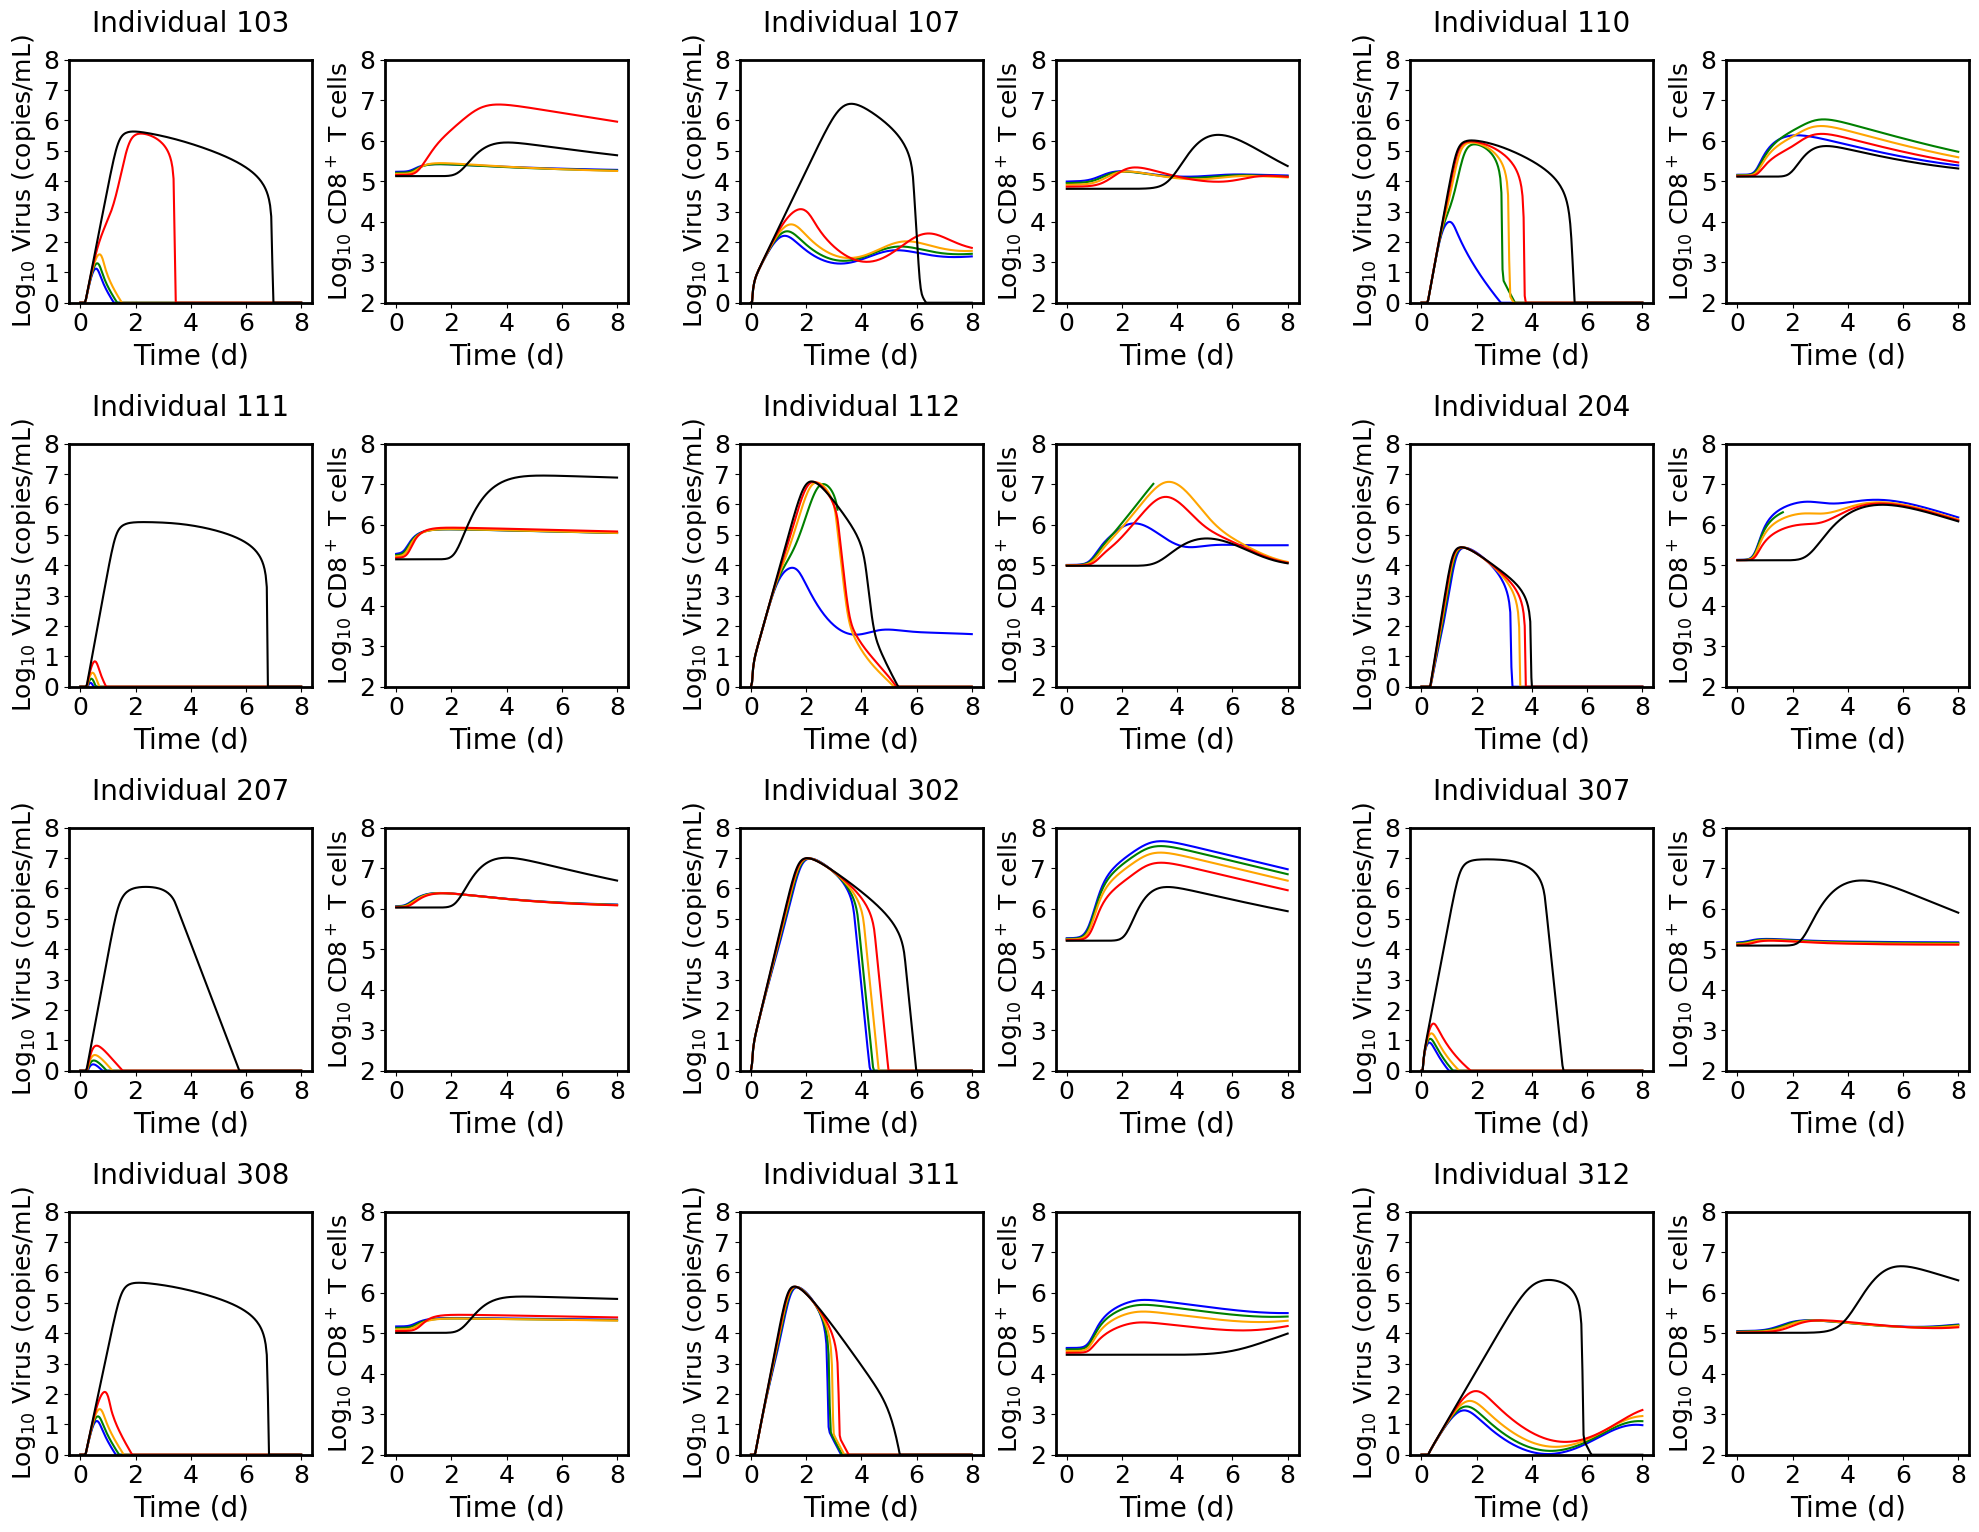

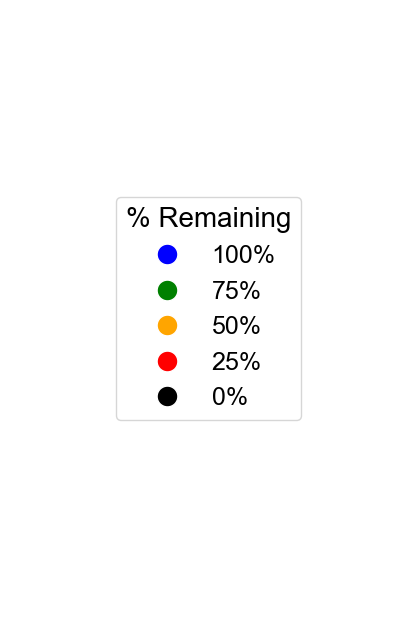

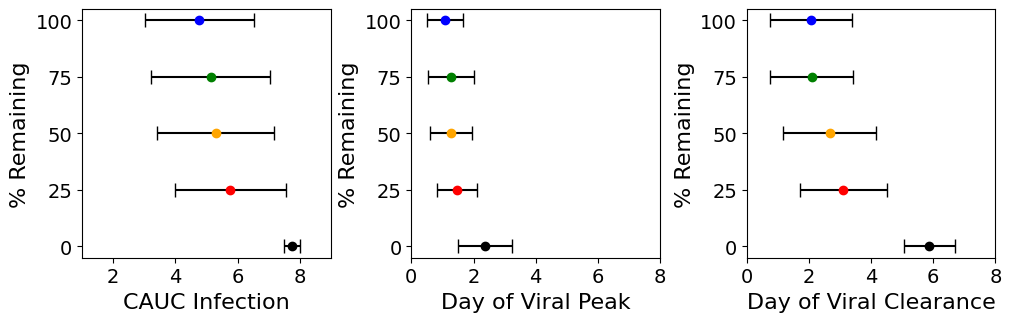

In [43]:
def run_simulation_decay(t_span, y0, base_params, percent_list):
    t_fill = np.linspace(t_span[0], t_span[-1], 200)
    t_int = np.arange(t_span[0], t_span[-1] + 1)
    t_span_full = np.unique(np.concatenate([np.array(t_span), t_fill, t_int]))
    
    param_order = ["beta", "k", "p", "c", "delta", "xi", "a", 
                   "d_E", "delta_E", "K_delta_E", "zeta", "eta", "K_I1", 
                   "tau_memory", "damp"]
    
    solutions = []
    cauc_values, cauc_infected_values, peak_days, clear_days = [], [], [], []
    
    for percent_remaining in percent_list:
        decayed_MP0 = base_params["MP0"] * (percent_remaining / 100.0)
        y0_sim = y0.copy()
        y0_sim[0] = base_params["T0"]
        y0_sim[5] = decayed_MP0
        y0_sim = [float(x) for x in y0_sim]
        
        params_py = [float(np.float64(base_params[k])) for k in param_order]
        params_julia = Main.eval("[" + ",".join(map(str, params_py)) + "]")
        
        result = Main.tmap_ReinfectionModel(t_span_full, y0_sim, params_julia)
        t_values, y_values = result[0]
        sol = {"t": np.array(t_values, dtype=np.float64),
               "y": np.array(y_values, dtype=np.float64),
               "percent_remaining": percent_remaining,
               "decayed_MP0": decayed_MP0}
        # add background level to Memory and Effector T cells
        sol['y'][4] += base_params['E0']
        sol['y'][5] += base_params['M0']
        solutions.append(sol)
        
        # Compute CAUC Virus
        t_arr = sol["t"]
        virus = sol["y"][3, :]
        auc_virus = np.trapezoid(virus, t_arr)
        cauc_values.append(auc_virus)
        
        # Compute CAUC Infected Cells (I1 + I2)
        infected_cells = sol["y"][1, :] + sol["y"][2, :]
        auc_infected = np.trapezoid(infected_cells, t_arr)
        cauc_infected_values.append(auc_infected)
        
        # Peak day calculation
        peak_idx = np.argmax(virus)
        peak_days.append(t_arr[peak_idx])
        
        # Clearance day calculation
        clear_time = np.nan
        for j in range(peak_idx + 1, len(t_arr)):
            if virus[j] < 1:
                clear_time = t_arr[j]
                break
        clear_days.append(clear_time)
        
    
    sim_data = {
        "percent_list": np.array(percent_list, dtype=np.float64),
        "solutions": solutions,
        "cauc_values": np.array(cauc_values, dtype=np.float64),
        "cauc_infected_values": np.array(cauc_infected_values, dtype=np.float64),
        "peak_days": np.array(peak_days, dtype=np.float64),
        "clear_days": np.array(clear_days, dtype=np.float64),
        "base_MP0": base_params["MP0"]
    }
    return sim_data

def plot_individual_dynamics_decay(fig, cell_gs, sim_data, indiv_id, color_map):
    gs_dyn = mpl.gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=cell_gs, wspace=0.3)
    ax_virus = fig.add_subplot(gs_dyn[0])
    ax_effector = fig.add_subplot(gs_dyn[1])
    
    # Style spines as in the primary function.
    for spine in ax_virus.spines.values():
        spine.set_color('black')
        spine.set_linewidth(2)
    for spine in ax_effector.spines.values():
        spine.set_color('black')
        spine.set_linewidth(2)
    
    percent_list = sim_data["percent_list"]
    solutions = sim_data["solutions"]
    
    # Plot simulation traces for each decay level.
    for sol in solutions:
        percent_val = sol["percent_remaining"]
        color = color_map.get(percent_val, 'gray')  # Default to gray if not found
        ax_virus.plot(sol["t"], np.log10(np.maximum(sol["y"][3, :], 1)),
                      color=color, linewidth=1.5)
        ax_effector.plot(sol["t"], np.log10(np.maximum(sol["y"][4, :] + sol["y"][5, 0], 1)),
                         color=color, linewidth=1.5)
    
    ax_virus.set_yticks(np.arange(0, 9, 1))
    ax_effector.set_yticks(np.arange(2, 9, 1))
    ax_virus.set_xticks([0, 2, 4, 6, 8])
    ax_effector.set_xticks([0, 2, 4, 6, 8])
    ax_virus.set_ylabel('Log$_{10}$ Virus (copies/mL)', fontsize=18)
    ax_effector.set_ylabel('Log$_{10}$ CD8$^+$ T cells', fontsize=18)
    ax_virus.set_xlabel("Time (d)", fontsize=20)
    ax_effector.set_xlabel("Time (d)", fontsize=20)
    ax_virus.tick_params(labelsize=18)
    ax_effector.tick_params(labelsize=18)
    ax_virus.set_ylim(0, 8)
    ax_effector.set_ylim(2, 8)
    ax_virus.set_box_aspect(1)
    ax_effector.set_box_aspect(1)
    
    # Set individual title centered over ax_virus and ax_effector
    ax_virus.set_title(f"Individual {indiv_id}", fontsize=20, ha='center', pad=20)

    # Save the dynamics figure as SVG
    plt.savefig(f'../plots/sensitivity/memory/dynamics_{indiv_id}_decay.svg', format='svg', bbox_inches='tight')

def create_global_colorbar_decay(fig, color_map, save_path=None):
    ax = fig.add_subplot(111)

    legend_elements = []
    percents = sorted(color_map.keys(), reverse=True)
    
    for percent in percents:
        color = color_map[percent]
        legend_elements.append(
            Line2D([0], [0], marker='o', color='w', markerfacecolor=color,
                   markersize=15, label=f"{percent}%")
        )
    
    ax.set_axis_off()
    legend = ax.legend(handles=legend_elements, 
                       loc='center',  # Center the legend
                       title="% Remaining",
                       prop={'family': 'Arial', 'size': 18},
                       frameon=True)
    
    legend.get_title().set_fontfamily('Arial')
    legend.get_title().set_fontsize(20)
    fig.tight_layout(pad=0.1)
    
    if save_path:
        fig.savefig(save_path, format='svg', bbox_inches='tight')
    
    return legend

def plot_summary_metrics_decay(fig, cell_gs, sim_data_list, color_map):
    # Create a GridSpec for three rows and one column.
    gs_met = mpl.gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=cell_gs, hspace=0)
    ax_auc_inf = fig.add_subplot(gs_met[0])
    ax_peak    = fig.add_subplot(gs_met[1])
    ax_clear   = fig.add_subplot(gs_met[2])
    
    color_map = {key: to_rgb(value) for key, value in color_map.items()}

    base_data = sim_data_list[0]
    x_metric = np.array(base_data["percent_list"][::-1])  # Reverse the order of x_metric
    
    # Define the three metric extraction functions.
    metric_funcs = [
        lambda d: np.log10(d["cauc_infected_values"]),
        lambda d: d["peak_days"],
        lambda d: d["clear_days"]
    ]
    ylabels = ['CAUC Infection', 'Day of Viral Peak', 'Day of Viral Clearance']
    
    # Set the x-axis bounds for each metric.
    x_bounds = [(1, 9), (0, 8), (0, 8)]
    
    # Loop over each metric axis.
    for ax, metric_func, ylabel, (x_lower, x_upper) in zip([ax_auc_inf, ax_peak, ax_clear],
                                                             metric_funcs, ylabels, x_bounds):
        means = []
        stds = []
        # For each % tick (assumed consistent across individuals)
        for tick in x_metric:
            vals = []
            for sim_data in sim_data_list:
                # Find the index closest to the current tick.
                idx = np.argmin(np.abs(np.array(sim_data["percent_list"]) - tick))
                val = metric_func(sim_data)[idx]
                if np.isfinite(val):
                    vals.append(val)
            vals = np.array(vals)
            if vals.size > 0:
                means.append(np.mean(vals))
                stds.append(np.std(vals))
            else:
                means.append(np.nan)
                stds.append(np.nan)
        means = np.array(means)
        stds = np.array(stds)
        
        # Adjust error bars so that (mean ± error) stays within defined x-bounds.
        lower_err = np.minimum(means - x_lower, stds)
        upper_err = np.minimum(x_upper - means, stds)
        xerr = np.vstack([lower_err, upper_err])
        
        # Plot each data point separately to assign individual colors.
        for i, (mean, tick) in enumerate(zip(means, x_metric)):
            ax.errorbar(mean, tick, xerr=[[lower_err[i]], [upper_err[i]]],
                        fmt='o', color=color_map[int(tick)], ecolor='black', capsize=5, zorder=5)
        
        ax.set_xlabel(ylabel, fontsize=16)
        ax.set_xlim(x_lower, x_upper)
        
    # Apply uniform tick parameters and aspect ratio.
    for i, ax in enumerate([ax_auc_inf, ax_peak, ax_clear]):
        ax.set_box_aspect(1)
        ax.tick_params(axis='y', labelsize=14)
        ax.tick_params(axis='x', labelsize=14)
        ax.set_xticks([0, 2, 4, 6, 8])  # Set x ticks at 0, 2, 4, 6, 8
        ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))  # Format x ticks as integers
        ax.set_ylabel("% Remaining", fontsize=16)
        ax.set_yticks(x_metric)
        ax.set_yticklabels([f"{int(val)}" for val in x_metric], fontsize=14)
        ax.set_xlim(x_bounds[i])

    
    plt.savefig(f'../plots/sensitivity/memory/summary_metrics_decay.svg', format='svg', bbox_inches='tight')

# Main block for decay sweep simulations.
t_span = (0.0, 8)
y0_master = [0, 75.0, 0.0, 0.0, 0.0, 0.0] + [0.0]*13
# Decay levels given as percentages (e.g. 100 means 100% of base ME)
percent_list = [100, 75, 50, 25, 0]
sim_data_dict = {}
for indiv_id in ids:
    row = params[params['id'] == indiv_id].iloc[0]
    base_params = {
        "E0": row['E0'],
        "M0": row['M0'],
        "T0": row['T0'],
        "beta": row['beta'],
        "k": row['k'],
        "p": row['p'],
        "c": row['c'],
        "delta": row['delta'],
        "xi": row['xi'],
        "a": row['a'],
        "d_E": row['d_E'],
        "delta_E": row['delta_E'],
        "K_delta_E": row['K_delta_E'],
        "zeta": row['zeta'],
        "eta": row['eta'],
        "K_I1": row['K_I1'],
        "tau_memory": row['tau_memory'],
        "damp": row['damp'],
        "MP0": row['MP0']
    }
    Zero_conditions = {"MP0": row['MP0'], "M0": row['M0']}
    y0_local = y0_master.copy()
    sim_data = run_simulation_decay(t_span, y0_local, base_params, percent_list)
    sim_data_dict[indiv_id] = (sim_data, Zero_conditions)

n_indiv = len(ids)
n_cols = 3
n_rows = math.ceil(n_indiv / n_cols)

color_map = {
    100: 'blue',
    75: 'green',
    50: 'orange',
    25: 'red',
    0: 'black',
}

os.makedirs('../plots/sensitivity/memory', exist_ok=True)
# Dynamics
fig_dyn = plt.figure(figsize=(20, 16))
outer_gs_dyn = gridspec.GridSpec(n_rows, n_cols, figure=fig_dyn)
for i, indiv_id in enumerate(ids):
    cell_gs = outer_gs_dyn[i]
    sim_data, Zero_conditions = sim_data_dict[indiv_id]
    plot_individual_dynamics_decay(fig_dyn, cell_gs, sim_data, indiv_id, color_map)
plt.subplots_adjust(left=0.03, right=0.98, top=0.95, bottom=0.03)
plt.show()

# Colorbar
fig_cbar = plt.figure(figsize=(4, 6))  
rep_sim = sim_data_dict[ids[0]][0]
legend = create_global_colorbar_decay(fig_cbar, color_map, save_path='../plots/sensitivity/MemoryLegend.svg')
plt.show()

# Summary Metrics
fig_summary = plt.figure(figsize=(10, 8), constrained_layout=True)
gs_summary = gridspec.GridSpec(ncols=1, nrows=1, figure=fig_summary)
cell_gs = gs_summary[0]
sim_data_list = [sim_data for sim_data, _ in sim_data_dict.values()]
plot_summary_metrics_decay(fig_summary, cell_gs, sim_data_list, color_map)
plt.show()